In [1]:
# Created by: Chen Da
# Created on: 20190115

In [2]:
import pandas as pd
import numpy as np
import random, warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

In [3]:
def split_func(data_frame, size=0.8):
    """
    Split the data into two data set
    :param data_frame: the name of input data
    :param size : the size of train data
    :return: train_data, test_data
    """
    data_frame = pd.DataFrame(data_frame.values,
                              index=[i for i in range(data_frame.values.shape[0])],
                              columns=data_frame.columns)
    healthy_data = data_frame[data_frame["class"] == 0]
    unhealthy_data = data_frame[data_frame["class"] == 1]
    healthy_index = list(healthy_data.index)
    unhealthy_index = list(unhealthy_data.index)
    healthy_train_data_index = random.sample(healthy_index, int(size * len(healthy_index)))
    unhealthy_train_data_index = random.sample(unhealthy_index, int(size * len(unhealthy_index)))
    healthy_test_data_index = list(set(healthy_index).difference(set(healthy_train_data_index)))
    unhealthy_test_data_index = list(set(unhealthy_index).difference(set(unhealthy_train_data_index)))
    train_index = list(set(healthy_train_data_index).union(set(unhealthy_train_data_index)))
    test_index = list(set(healthy_test_data_index).union(set(unhealthy_test_data_index)))
    train = data_frame.iloc[train_index, :]
    test = data_frame.iloc[test_index, :]
    return train, test

In [4]:
def balance_train(df, more_label=0, less_label=1):
    more_df = df[df['class']==more_label]
    less_df = df[df['class']==less_label]
    less_num = less_df.shape[0]
    more_index = list(more_df.index)
    index_choose = random.sample(more_index, less_num)
    df_choose = more_df.loc[index_choose, :]
    df_new = df_choose.append(less_df)
    return df_new

In [5]:
def final_model(df):
    predict_score = list()
    for info in range(df.shape[0]):
        new_data = df.iloc[info, :].values[1:-1]
        z = np.dot(new_data, coefs) + intercept
        y = 1 / (1 + np.exp(-z))
        predict_score.append(y)
    predict_df = pd.DataFrame(predict_score, columns=['pro'])
    df.index = [i for i in range(df.shape[0])]
    predict_df['id'] = df['id']
    predict_df['class'] = df['class']
    predict_df = predict_df.reindex(columns=['id', 'pro', 'class'])
    positive = predict_df[predict_df['class'] == 1]
    negtive = predict_df[predict_df['class'] == 0]
    plt.figure(figsize=(20, 12))
    plt.scatter(x=positive['id'], y=positive['pro'], color='red')
    plt.scatter(x=negtive['id'], y=negtive['pro'], color='blue')
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.6)
    plt.axhline(y=0.95, color='grey', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    return predict_df

In [7]:
path = 'C:/Users/pc/OneDrive/PLTTECH/Project/02_Disease_early_screening/lung_cancer/rawdata/'
df_name = 'marker_all'
df = pd.read_excel(path + df_name + '.xlsx')
df['id'] = df['id'].apply(lambda x:str(x))
df.columns

Index(['id', 'CD3', 'CD4', 'CD57', 'CD56', 'gdTCR', 'CD8', 'CD14', 'Igd',
       'CD123', 'CD85j', 'CD19', 'CD25', 'CD39', 'CD27', 'CD24', 'CD45RA',
       'CD86', 'CD28', 'CD197', 'CD11c', 'CD33', 'CD152', 'CD161', 'CXCR5',
       'CD183', 'CD94', 'CD127', 'PD1', 'CD20', 'CD16', 'HLA_DR', 'CD11b',
       'CCR6', 'CD38', 'CD274', 'CD278', 'class'],
      dtype='object')

In [8]:
selected_marker = ['id', 'CD3', 'CD4', 'CD57', 'CD56', 'gdTCR', 'CD8', 'CD14', 'Igd',
                   'CD123', 'CD19', 'CD25', 'CD39', 'CD27', 'CD24', 'CD45RA',
                   'CD86', 'CD28', 'CD11c', 'CD33', 'CD152', 'CD161', 'CXCR5',
                   'CD183', 'CD94', 'CD127', 'PD1', 'CD20', 'HLA_DR', 'CD11b',
                   'CCR6', 'CD38', 'CD274', 'CD278', 'class']       
df = df.loc[:, selected_marker]
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].multiply(100)
stdsc = StandardScaler()
df.iloc[:, 1:-1] = pd.DataFrame(stdsc.fit_transform(df.iloc[:, 1:-1].values), columns=df.columns[1:-1])
df.shape

(318, 35)

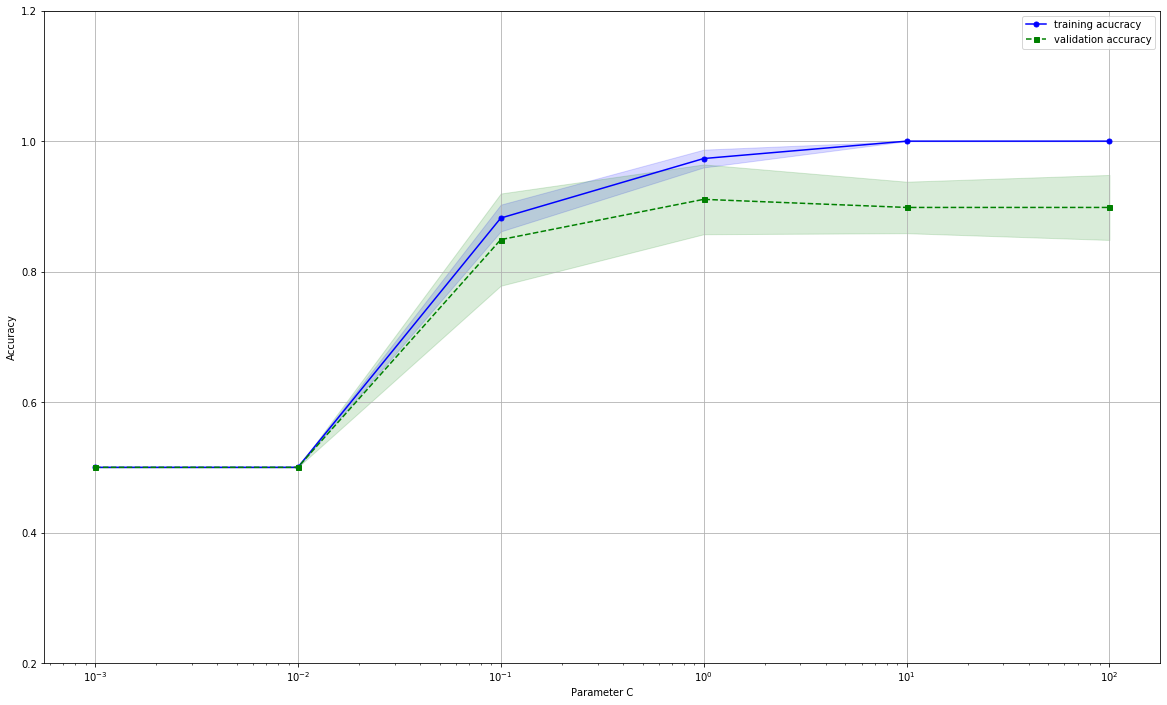

In [11]:
## 划分训练集和测试集
train_df_raw, test_df = split_func(df)
train_df = balance_train(train_df_raw)
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['class'].values.astype('int')
X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['class'].values.astype('int')
# X_train = df.iloc[:, 1:-1].values
# y_train = df['class'].values.astype('int')


# 通过验证曲线来确定正则参数
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.6)
clf = LogisticRegression(penalty='l1')
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, 
                                             y=y_train,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,12))
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training acucracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.show()                

In [23]:
# lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.6, C=0.01)
lr = LogisticRegression(penalty='l1', C=0.8)
lr.fit(X_train, y_train)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# help(LogisticRegression)

In [25]:
lr.score(X_train, y_train)

0.9606741573033708

In [26]:
lr.score(X_test, y_test)

0.8923076923076924

In [27]:
coefs = list(lr.coef_[0])
intercept = lr.intercept_[0]
select_subsets_id = [list(lr.coef_[0]).index(i) for i in list(lr.coef_[0]) if i != 0]
select_subsets = [list(df.columns[1:-1])[i] for i in select_subsets_id]
print(len(select_subsets))
select_subsets.append('class')
select_subsets.insert(0, 'id')
print(select_subsets)
coefs = [i for i in coefs if i != 0]
print(coefs)
print(intercept)

17
['id', 'CD4', 'CD57', 'gdTCR', 'CD8', 'CD14', 'CD25', 'CD11c', 'CD152', 'CXCR5', 'CD183', 'CD94', 'CD127', 'PD1', 'CD11b', 'CCR6', 'CD274', 'CD278', 'class']
[-0.8459815168219227, -0.36555767856494337, 0.14164486230833692, 0.7707156368877089, -1.1315770767373436, -0.8529934591964614, 0.7270000458980042, 0.16606039823022928, -1.124911435229016, 1.5018399654147898, 0.6464951495205371, 1.0347172545909542, -0.47989625430389077, -0.35030070023958215, 0.5276478176403758, -1.1135477519942079, 0.991783930303216]
-1.0975572222455543


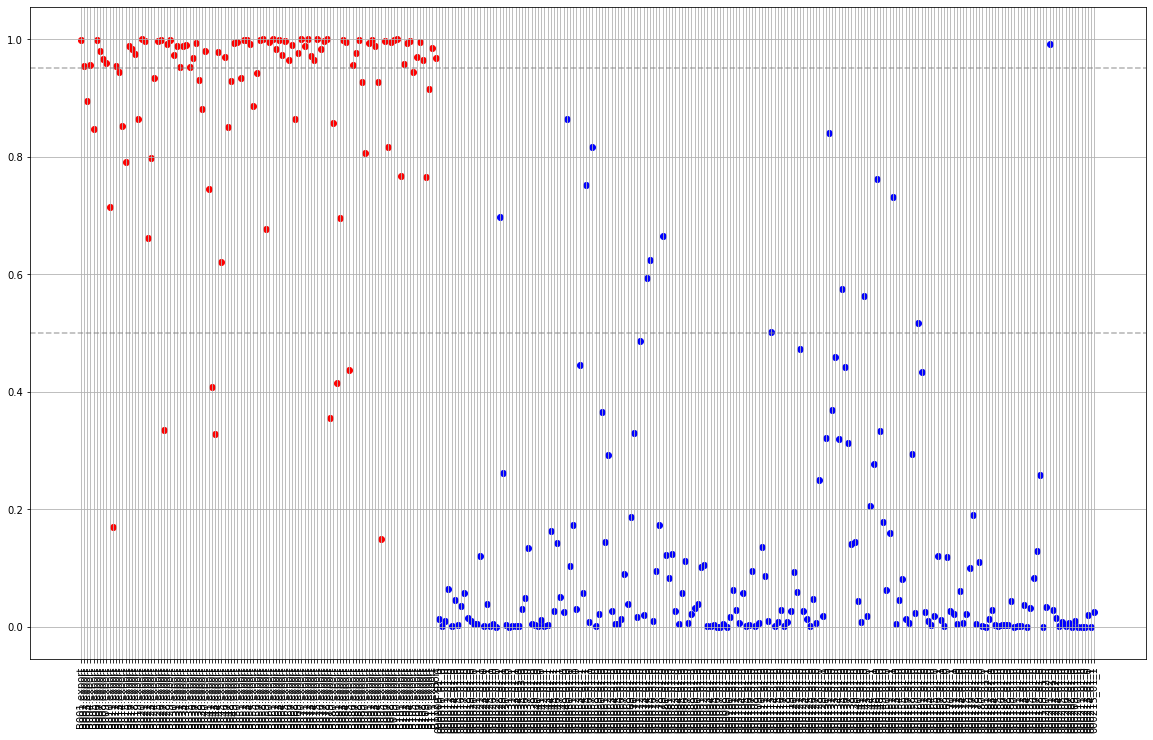

总体准确率为0.9276729559748428


In [28]:
test_all = pd.read_excel(path + 'marker_all.xlsx').loc[:, selected_marker]
test_all.iloc[:, 1:-1] = test_all.iloc[:, 1:-1].multiply(100)
test_all.iloc[:, 1:-1] = stdsc.transform(test_all.iloc[:, 1:-1])
test_all = test_all.loc[:, select_subsets]
pre_test_all = final_model(test_all)

In [15]:
# pre_train = final_model(train_df_raw.loc[:, select_subsets])

In [16]:
# pre_test = final_model(test_df.loc[:, select_subsets])

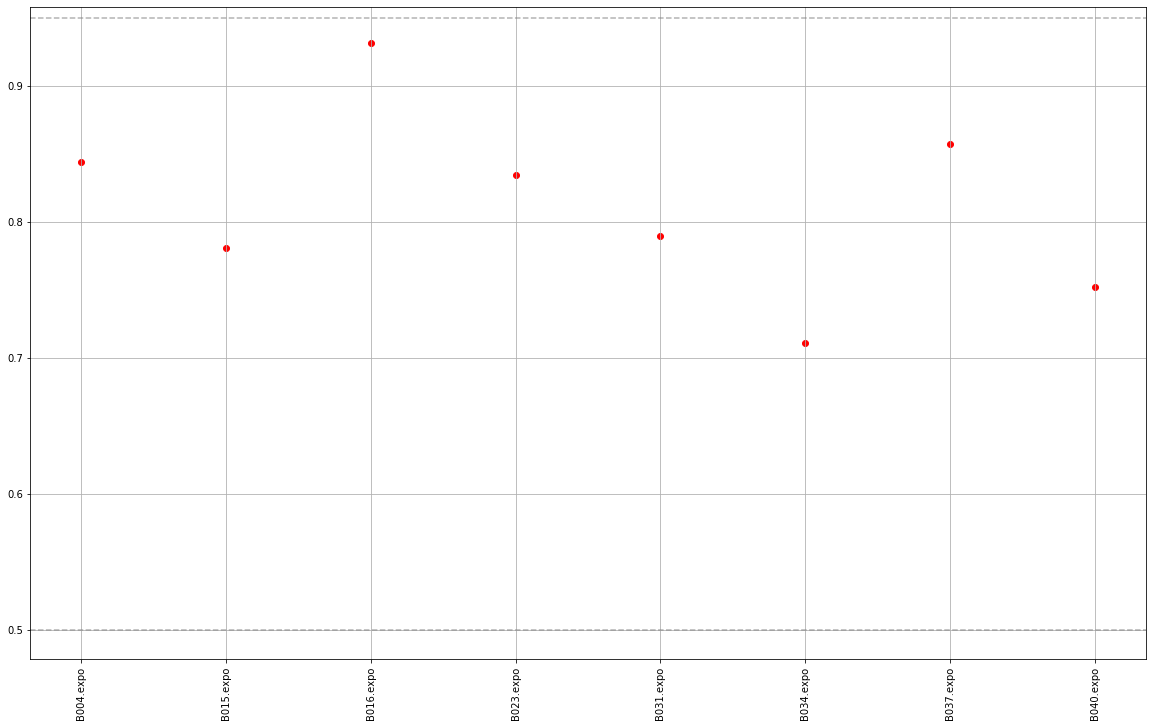

总体准确率为1.0


In [86]:
benign_new = pd.read_excel(path + 'rawdata/marker_benign.xlsx').loc[:, selected_marker]
benign_new.iloc[:, 1:-1] = benign_new.iloc[:, 1:-1].multiply(100)
benign_new.iloc[:, 1:-1] = stdsc.transform(benign_new.iloc[:, 1:-1])
benign_new = benign_new.loc[:, select_subsets]
pre_benign_new = final_model(benign_new)

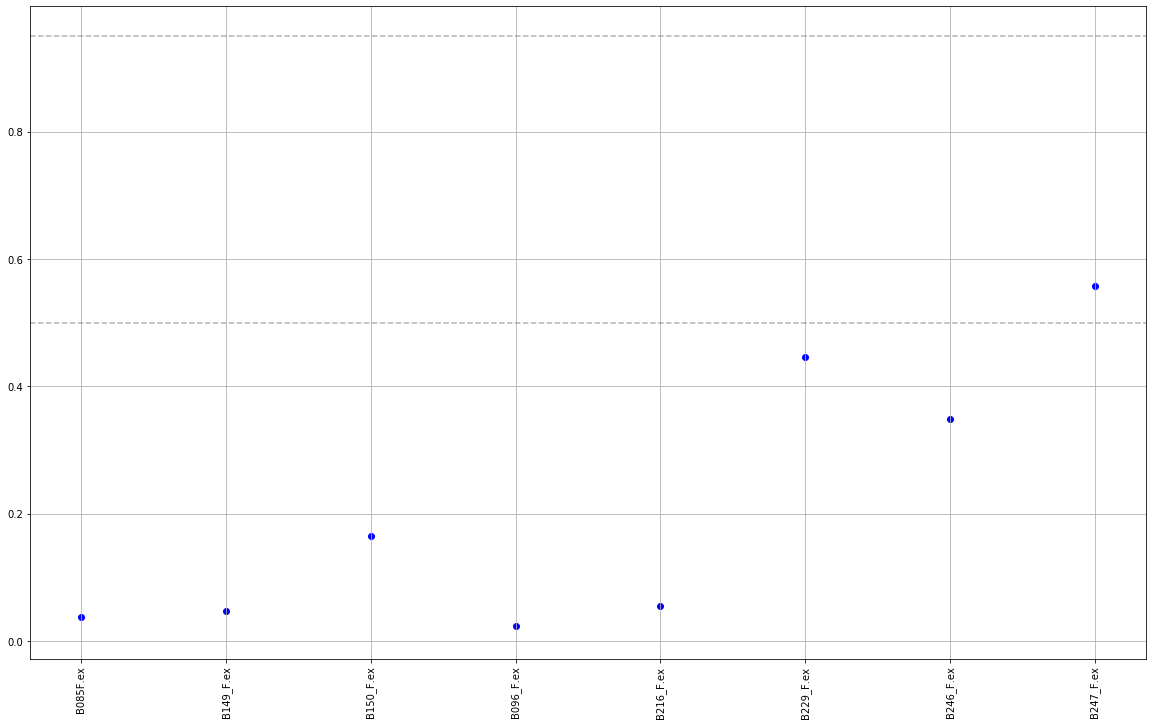

总体准确率为0.875


In [87]:
PLT_healthy_new = pd.read_excel(path + 'rawdata/marker_PLT_healthy.xlsx').loc[:, selected_marker]
PLT_healthy_new.iloc[:, 1:-1] = PLT_healthy_new.iloc[:, 1:-1].multiply(100)
PLT_healthy_new.iloc[:, 1:-1] = stdsc.transform(PLT_healthy_new.iloc[:, 1:-1])
PLT_healthy_new = PLT_healthy_new.loc[:, select_subsets]
pre_PLT_healthy_new = final_model(PLT_healthy_new)

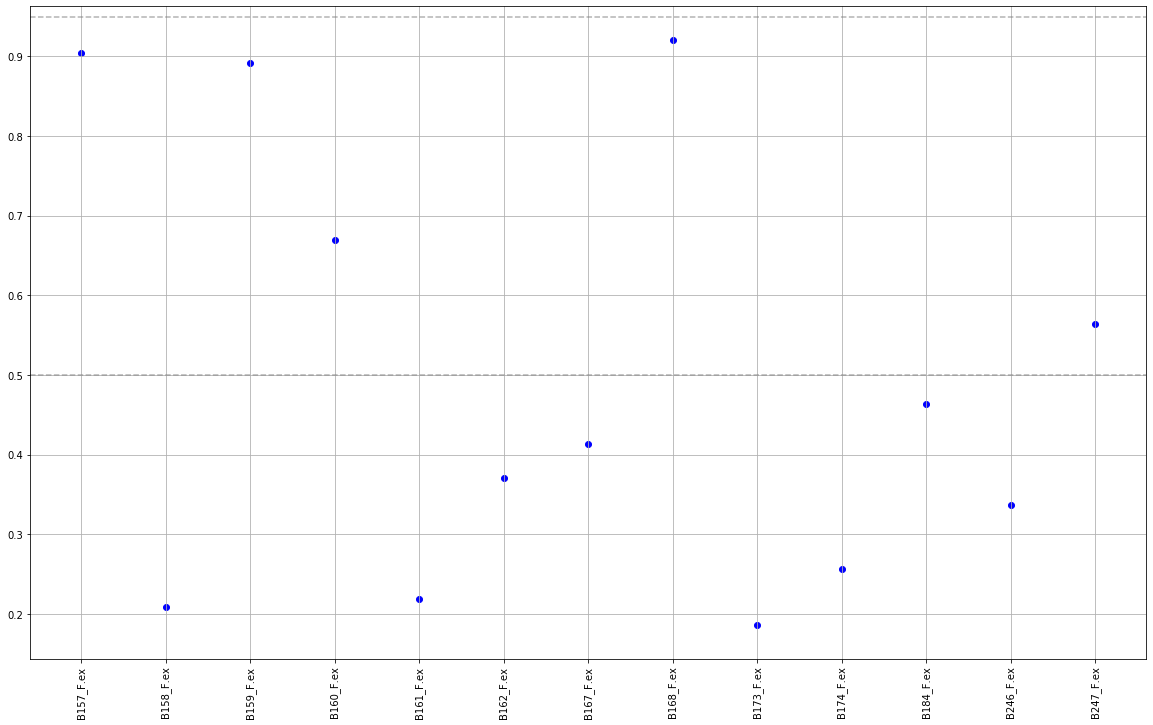

总体准确率为0.6153846153846154


In [88]:
pulmonary_nodule = pd.read_excel(path + 'rawdata/marker_pulmonary_nodule.xlsx').loc[:, selected_marker]
pulmonary_nodule.iloc[:, 1:-1] = pulmonary_nodule.iloc[:, 1:-1].multiply(100)
pulmonary_nodule.iloc[:, 1:-1] = stdsc.transform(pulmonary_nodule.iloc[:, 1:-1])
pulmonary_nodule = pulmonary_nodule.loc[:, select_subsets]
pre_pulmonary_nodule = final_model(pulmonary_nodule)